# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [186]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets, ensemble, model_selection, metrics, tree, linear_model

from matplotlib import pyplot as plt

In [67]:
data, target = datasets.load_boston(return_X_y=True)

In [68]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size = 0.25, shuffle=False)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [ ]:
2(a(x) - y)

In [56]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return np.sum([coeff * algo.predict(X) for algo, coeff in zip(base_algorithms_list, coefficients_list)], axis=0)

In [88]:
base_algorithms_list = np.array([tree.DecisionTreeRegressor(max_depth=5, random_state=42) for i in range(50)])
coefficients_list = np.full(50, 0.9)

In [94]:
metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list, coefficients_list))**0.5

5.455623403859612

In [89]:
base_algorithms_list[8] is base_algorithms_list[0]

False

In [92]:
y_train_n = np.array(y_train)

for i in range(50):
    base_algorithms_list[i].fit(X_train, y_train_n)
    print(f'before {i}', y_train_n[:10])
    print('predict', gbm_predict(X_train, base_algorithms_list[:i+1], coefficients_list[:i+1])[:10])
    y_train_n = y_train - gbm_predict(X_train, base_algorithms_list[:i+1], coefficients_list[:i+1])
    print(f'after {i}', y_train_n[:10])


before 0 [24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9]
predict [24.102      20.48068966 31.8675     31.8675     31.8675     29.205
 18.40584906 17.55       17.55       17.55      ]
after 0 [-0.102       1.11931034  2.8325      1.5325      4.3325     -0.505
  4.49415094  9.55       -1.05        1.35      ]
before 1 [-0.102       1.11931034  2.8325      1.5325      4.3325     -0.505
  4.49415094  9.55       -1.05        1.35      ]
predict [24.0102     22.19925484 36.56328605 33.34403745 34.93779392 28.39185
 22.16414607 22.74486792 18.87822915 18.87822915]
after 1 [-0.0102     -0.59925484 -1.86328605  0.05596255  1.26220608  0.30815
  0.73585393  4.35513208 -2.37822915  0.02177085]
before 2 [-0.0102     -0.59925484 -1.86328605  0.05596255  1.26220608  0.30815
  0.73585393  4.35513208 -2.37822915  0.02177085]
predict [24.34648444 21.63489343 35.99892464 32.77967604 34.37343251 27.82748859
 22.50043052 23.08115237 19.21451359 19.21451359]
after 2 [-0.34648444 -0.03489343 -1.29892464

after 29 [-0.00872134  0.02498219 -0.00621692 -0.00042754  0.03983946 -0.0054914
  0.02809805  0.02306103 -0.01796648  0.06491462]
before 30 [-0.00872134  0.02498219 -0.00621692 -0.00042754  0.03983946 -0.0054914
  0.02809805  0.02306103 -0.01796648  0.06491462]
predict [24.00721437 21.57351085 34.70470996 33.39892058 36.15865357 28.70398443
 22.87039499 27.07543201 16.53370724 18.83357842]
after 30 [-0.00721437  0.02648915 -0.00470996  0.00107942  0.04134643 -0.00398443
  0.02960501  0.02456799 -0.03370724  0.06642158]
before 31 [-0.00721437  0.02648915 -0.00470996  0.00107942  0.04134643 -0.00398443
  0.02960501  0.02456799 -0.03370724  0.06642158]
predict [24.01187442 21.5781709  34.70145785 33.39566847 36.15869453 28.70864448
 22.87043594 27.07547296 16.5337482  18.83361937]
after 31 [-0.01187442  0.0218291  -0.00145785  0.00433153  0.04130547 -0.00864448
  0.02956406  0.02452704 -0.0337482   0.06638063]
before 32 [-0.01187442  0.0218291  -0.00145785  0.00433153  0.04130547 -0.0086

In [28]:
y_train_n = y_train

In [41]:
y_train[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [62]:
basealgs = []
coefs = []
s = y_train
for i in range(50):
    dt = tree.DecisionTreeRegressor (max_depth=5 , random_state=42)
    dt.fit(X_train, s)
    basealgs.append(dt)
    coef = 0.9
    coefs.append(coef)
    s = y_train - gbm_predict(X_train, basealgs, coefs)
    print(s[:10])
error = metrics.mean_squared_error(y_test, gbm_predict(X_test, basealgs, coefs))
ans1 = error ** 0.5
print(ans1)

[-0.102       1.11931034  2.8325      1.5325      4.3325     -0.505
  4.49415094  9.55       -1.05        1.35      ]
[-0.0102     -0.59925484 -1.86328605  0.05596255  1.26220608  0.30815
  0.73585393  4.35513208 -2.37822915  0.02177085]
[-0.34648444 -0.03489343 -1.29892464  0.62032396  1.82656749  0.87251141
  0.39956948  4.01884763 -2.71451359 -0.31451359]
[-0.69302823 -0.38143722 -1.3620521   0.27378017  1.4800237   0.52596762
  0.05302569  3.67230384 -1.89494248  0.50505752]
[-0.78287823  0.07804701 -1.4519021   0.18393018  1.39017371  0.43611763
 -0.03682431  0.36723038 -0.18949425  0.96454174]
[-0.15934048  0.29091599 -0.73302472 -0.04058951  1.16565402 -0.17460446
  0.17604468  0.26646523 -0.41368308  0.74035292]
[-0.64267153  0.24058674 -0.78335397 -0.09091876  1.11532477 -0.22493371
  0.22983     0.32025054 -0.35989776  0.79413823]
[-0.5233785   0.35987977 -0.66406095  0.11004306  1.2346178  -0.10564069
  0.34912302  0.43954357 -0.78533835  0.36869764]
[-0.55364066  0.32961761

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [95]:
base_algorithms_list = np.array([tree.DecisionTreeRegressor(max_depth=5, random_state=42) for i in range(50)])
y_train_n = np.array(y_train)

for i in range(50):
    base_algorithms_list[i].fit(X_train, y_train_n)
    coefficients_list[i] = 0.9 / (1.0 + i)
    y_train_n = y_train - gbm_predict(X_train, base_algorithms_list[:i+1], coefficients_list[:i+1])

metrics.mean_squared_error(y_test, gbm_predict(X_test, base_algorithms_list, coefficients_list))**0.5

4.812550945781193

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [176]:
%%time
param_grid = {'n_estimators': np.arange(1, 250, 15), 'max_depth': [1, 5, 50, 60, 100]}
estimator = xgb.XGBRegressor(learning_rate = 1)
sh = model_selection.GridSearchCV(estimator, param_grid, cv=4, n_jobs=-1).fit(data, target)

Wall time: 7.3 s


In [177]:
df = pd.DataFrame(sh.cv_results_)

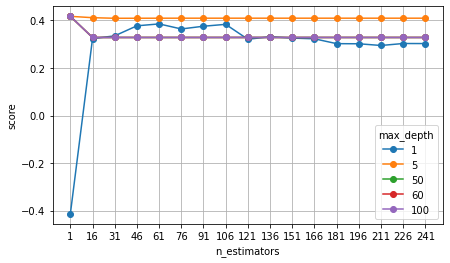

In [184]:
fig, ax = plt.subplots(figsize = (7, 4))
ax.grid(which='both')

for i in [1, 5, 50, 60, 100]:
    ax.plot(df[df['param_max_depth'] == i]['param_n_estimators'], df[df['param_max_depth'] == i]['mean_test_score'], marker='o', label=i)
ax.legend
ax.legend(loc='lower right', title='max_depth')
ax.set_xticks(np.arange(1, 250, 15))
ax.set_xlabel("n_estimators")
ax.set_ylabel("score")
    
plt.show()

In [179]:
%%time
param_grid = {'n_estimators': np.arange(1, 250, 15), 'max_depth': [1, 5, 50, 60, 100]}
estimator = ensemble.GradientBoostingRegressor(learning_rate=1)
sh = model_selection.GridSearchCV(estimator, param_grid, cv=4, n_jobs=-1).fit(data, target)

Wall time: 4.4 s


In [180]:
df_2 = pd.DataFrame(sh.cv_results_)

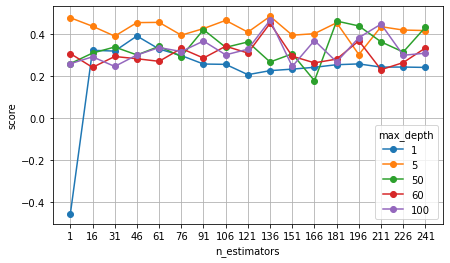

In [185]:
fig, ax = plt.subplots(figsize = (7, 4))
ax.grid(which='both')

for i in [1, 5, 50, 60, 100]:
    ax.plot(df_2[df_2['param_max_depth'] == i]['param_n_estimators'], df_2[df_2['param_max_depth'] == i]['mean_test_score'], marker='o', label=i)
ax.legend
ax.legend(loc='lower right', title='max_depth')
ax.set_xticks(np.arange(1, 250, 15))
ax.set_xlabel("n_estimators")
ax.set_ylabel("score")
    
plt.show()

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [188]:
len_reg = linear_model.LinearRegression().fit(X_train, y_train)

In [189]:
metrics.mean_squared_error(y_test, len_reg.predict(X_test))**0.5

8.25497975354908